# 0. Import & install

In [1]:
# pip install pyarrow

In [2]:
import dask.dataframe as dd#similar to pandas

import pandas as pd#pandas to create small dataframes 

# unix time: https://www.unixtimestamp.com/
import datetime #Convert to unix time

import time #Convert to unix time

# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays

from matplotlib import rcParams#Size of plots  

import matplotlib.pylab as plt
import seaborn as sns#Plots

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os

# to install xgboost: pip3 install xgboost
# if it didnt happen check install_xgboost.JPG
import xgboost as xgb


# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# 1. Data Load

In [3]:
df = pd.read_parquet('yellow_tripdata_2019-01.parquet', engine='pyarrow') 

In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN,None
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN,None
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,None
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN,None
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN,None


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7696617 entries, 0 to 7696616
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [6]:
df.isna().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count            28672
trip_distance                  0
RatecodeID                 28672
store_and_fwd_flag         28672
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge     4884887
airport_fee              7696617
dtype: int64

# 2. preprocess & visualization

In [7]:
df=df.query("tpep_pickup_datetime >= '2019-01-01' and tpep_pickup_datetime <='2019-12-31'")
df=df.query("tpep_dropoff_datetime >= '2019-01-01' and tpep_dropoff_datetime <='2019-12-31'")

## 2-1. Trip Durations

In [8]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 

# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert thiss sting to python time formate and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    s = np.datetime_as_string(s, unit='s')
    s = s.replace('T', ' ')
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())




# we return a data frame which contains the columns
# 1.'passenger_count' : self explanatory
# 2.'trip_distance' : self explanatory
# 3.'pickup_longitude' : self explanatory
# 4.'pickup_latitude' : self explanatory
# 5.'dropoff_longitude' : self explanatory
# 6.'dropoff_latitude' : self explanatory
# 7.'total_amount' : total fair that was paid
# 8.'trip_times' : duration of each trip
# 9.'pickup_times : pickup time converted into unix time 
# 10.'Speed' : velocity of each trip
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']]
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','PULocationID','DOLocationID','total_amount']]
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

frame_with_durations = return_with_trip_times(df)
print(frame_with_durations.head())

   passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0              1.0            1.5           151           239          9.95   
1              1.0            2.6           239           246         16.30   
7              1.0            1.3           163           229          9.05   
8              1.0            3.7           229             7         18.50   
9              2.0            2.1           141           234         13.00   

   trip_times  pickup_times      Speed  
0    6.666667  1.546271e+09  13.500000  
1   19.200000  1.546272e+09   8.125000  
7    7.150000  1.546270e+09  10.909091  
8   13.633333  1.546270e+09  16.283619  
9   12.000000  1.546272e+09  10.500000  


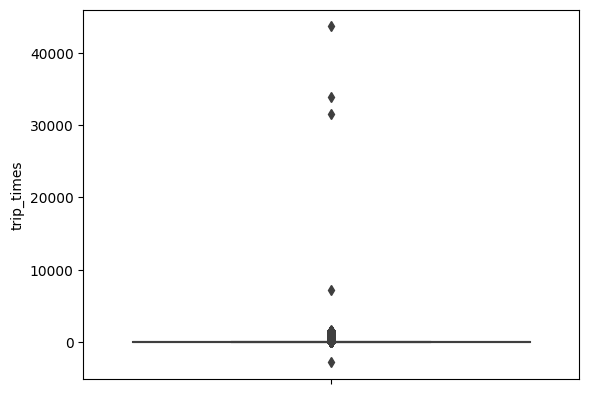

In [9]:
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

In [10]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -2838.233333333333
10 percentile value is 3.783333333333333
20 percentile value is 5.366666666666666
30 percentile value is 6.85
40 percentile value is 8.433333333333334
50 percentile value is 10.183333333333334
60 percentile value is 12.266666666666667
70 percentile value is 14.95
80 percentile value is 18.783333333333335
90 percentile value is 25.65
100 percentile value is  43648.01666666667


In [11]:
#looking further from the 99th percecntile
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 25.65
91 percentile value is 26.75
92 percentile value is 28.0
93 percentile value is 29.416666666666668
94 percentile value is 31.066666666666666
95 percentile value is 33.11666666666667
96 percentile value is 35.666666666666664
97 percentile value is 39.083333333333336
98 percentile value is 44.15
99 percentile value is 53.71666666666667
100 percentile value is  43648.01666666667


In [12]:
#removing data based on our analysis and TLC regulations
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

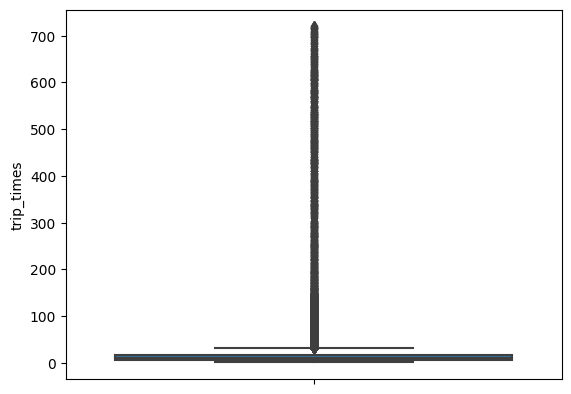

In [13]:
#box-plot after removal of outliers
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

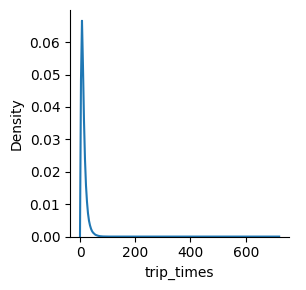

In [14]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified).map(sns.kdeplot,"trip_times").add_legend()
plt.show()

In [15]:
#converting the values to log-values to chec for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

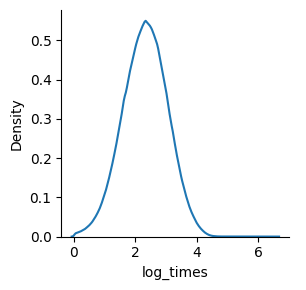

In [16]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified) \
      .map(sns.kdeplot,"log_times") \
      .add_legend()
plt.show()


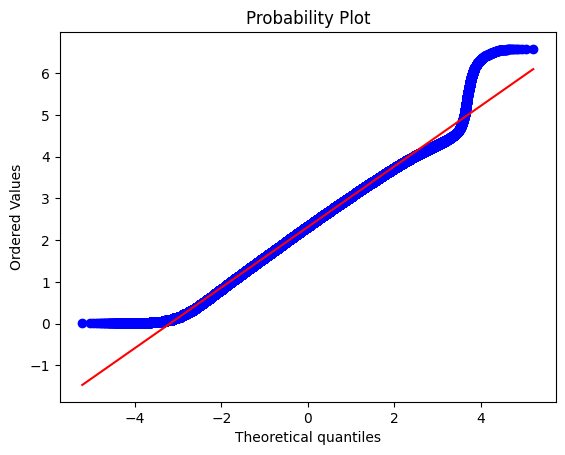

In [17]:
#Q-Q plot for checking if trip-times is log-normal
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

## 2-2. Speed

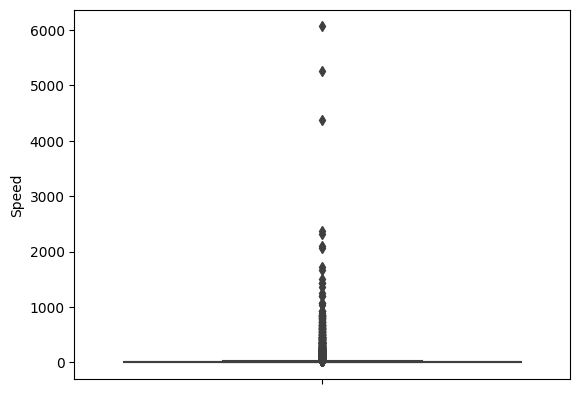

In [18]:
# check for any outliers in the data after trip duration outliers removed
# box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [19]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 5.845544554455445
20 percentile value is 7.1265746850629865
30 percentile value is 8.148148148148149
40 percentile value is 9.116129032258065
50 percentile value is 10.134048257372655
60 percentile value is 11.302904564315352
70 percentile value is 12.799999999999999
80 percentile value is 15.049180327868855
90 percentile value is 19.636363636363637
100 percentile value is  6063.75


In [20]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 19.636363636363637
91 percentile value is 20.41318681318681
92 percentile value is 21.298245614035086
93 percentile value is 22.304347826086953
94 percentile value is 23.462321792260692
95 percentile value is 24.814285714285713
96 percentile value is 26.44642857142857
97 percentile value is 28.54368932038835
98 percentile value is 31.35080956052429
99 percentile value is 35.5736040609137
100 percentile value is  6063.75


In [21]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.5736040609137
99.1 percentile value is 36.153091265947005
99.2 percentile value is 36.775981524249424
99.3 percentile value is 37.4627539503386
99.4 percentile value is 38.2130249543518
99.5 percentile value is 39.072463768115945
99.6 percentile value is 40.04718945176961
99.7 percentile value is 41.23839009287926
99.8 percentile value is 42.84679245283019
99.9 percentile value is 45.28612716763006
100 percentile value is  6063.75


In [22]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.28)]

In [23]:
#avg.speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

11.6744849133077

## 2-3. Trip Distance

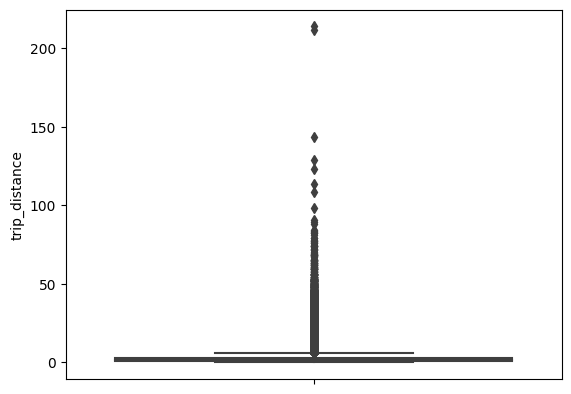

In [24]:
# up to now we have removed the outliers based on trip durations and cab speeds
# lets try if there are any outliers in trip distances
# box-plot showing outliers in trip-distance values
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

In [25]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.6
20 percentile value is 0.81
30 percentile value is 1.03
40 percentile value is 1.28
50 percentile value is 1.55
60 percentile value is 1.9
70 percentile value is 2.45
80 percentile value is 3.43
90 percentile value is 6.54
100 percentile value is  214.01


In [26]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 6.54
91 percentile value is 7.21
92 percentile value is 8.04
93 percentile value is 8.88
94 percentile value is 9.7
95 percentile value is 10.68
96 percentile value is 12.01
97 percentile value is 14.8
98 percentile value is 17.3
99 percentile value is 18.89
100 percentile value is  214.01


In [27]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.89
99.1 percentile value is 19.1
99.2 percentile value is 19.38
99.3 percentile value is 19.69
99.4 percentile value is 20.04
99.5 percentile value is 20.45
99.6 percentile value is 20.9
99.7 percentile value is 21.48
99.8 percentile value is 22.41
99.9 percentile value is 25.52
100 percentile value is  214.01


In [28]:
#removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<25.52)]


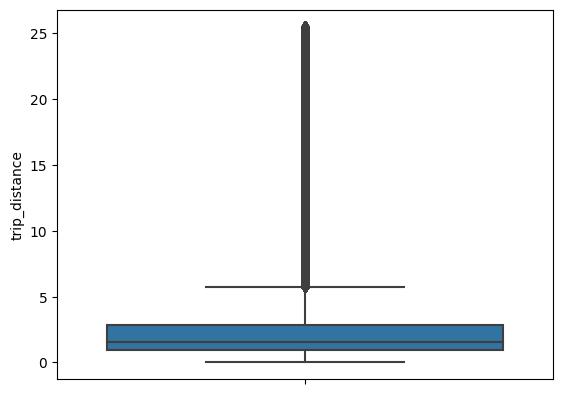

In [29]:
#box-plot after removal of outliers
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

## 2-4. Total Fare

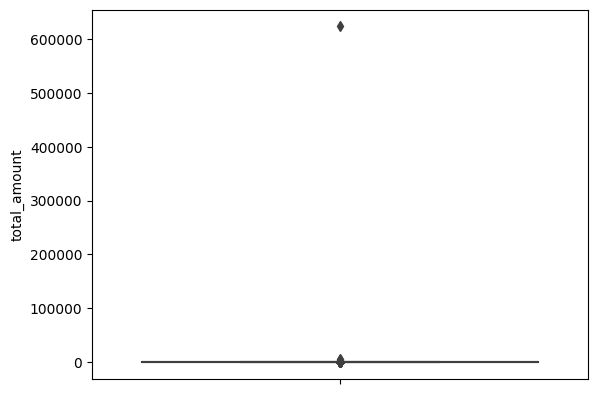

In [30]:
# up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# lets try if there are any outliers in based on the total_amount
# box-plot showing outliers in fare
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [31]:
#calculating total fare amount values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -322.3
10 percentile value is 6.36
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.96
50 percentile value is 11.3
60 percentile value is 12.95
70 percentile value is 15.3
80 percentile value is 18.8
90 percentile value is 28.55
100 percentile value is  623261.66


In [32]:
#calculating total fare amount values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 28.55
91 percentile value is 30.8
92 percentile value is 33.56
93 percentile value is 36.96
94 percentile value is 40.56
95 percentile value is 44.46
96 percentile value is 49.26
97 percentile value is 56.3
98 percentile value is 63.35
99 percentile value is 70.27
100 percentile value is  623261.66


In [33]:
#calculating total fare amount values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 70.27
99.1 percentile value is 70.27
99.2 percentile value is 70.27
99.3 percentile value is 71.32
99.4 percentile value is 73.2
99.5 percentile value is 73.56
99.6 percentile value is 75.67
99.7 percentile value is 76.13
99.8 percentile value is 81.96
99.9 percentile value is 95.3
100 percentile value is  623261.66


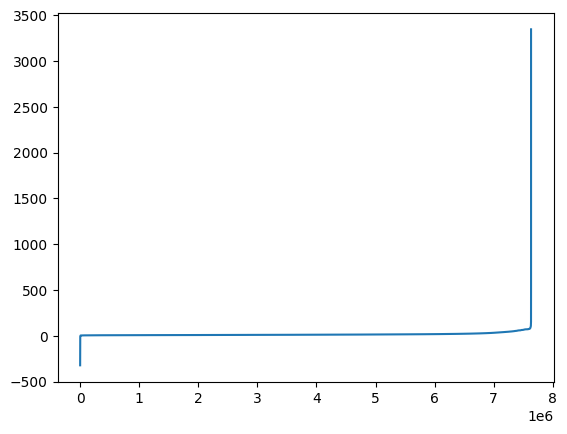

In [34]:
#below plot shows us the fare values(sorted) to find a sharp increase to remove those values as outliers
# plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

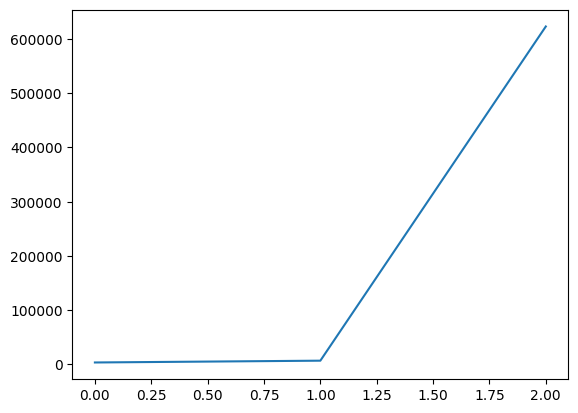

In [35]:
# a very sharp increase in fare values can be seen 
# plotting last three total fare values, and we can observe there is share increase in the values
plt.plot(var[-3:])
plt.show()

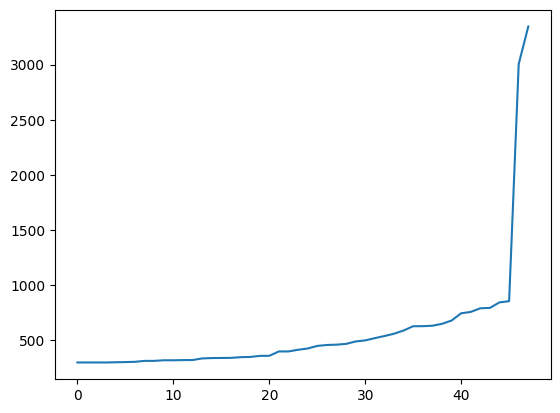

In [36]:
#now looking at values not including the last two points we again find a drastic increase at around 1000 fare value
# we plot last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()

## Remove all outliers/erronous points

In [37]:
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 25.52)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 45.28) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 25.52)]
    new_frame = new_frame[(new_frame.Speed < 45.28) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [38]:
print ("Removing outliers in the month of Jan-2019")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2019
----
Number of pickup records =  7696172
Number of outliers from trip times analysis: 26433
Number of outliers from trip distance analysis: 64266
Number of outliers from speed analysis: 20850
Number of outliers from fare analysis: 8789
Total outliers removed 103069
---
fraction of data points that remain after removing outliers 0.9866077577268284


In [39]:
frame_with_durations_outliers_removed.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,trip_times,pickup_times,Speed
0,1.0,1.5,151,239,9.95,6.666667,1.546271e+09,13.500000
1,1.0,2.6,239,246,16.30,19.200000,1.546272e+09,8.125000
7,1.0,1.3,163,229,9.05,7.150000,1.546270e+09,10.909091
8,1.0,3.7,229,7,18.50,13.633333,1.546270e+09,16.283619
9,2.0,2.1,141,234,13.00,12.000000,1.546272e+09,10.500000


## Data-preperation

## Time-binning

In [40]:
#Refer:https://www.unixtimestamp.com/
# 1546268400 : 2019-01-01 00:00:00 
# 1548946800 : 2019-02-01 00:00:00 
# 1551366000 : 2019-03-01 00:00:00
# 1554044400 : 2019-04-01 00:00:00 
# 1556636400 : 2019-05-01 00:00:00 
# 1559314800 : 2019-06-01 00:00:00

# 1577804400 : 2020-01-01 00:00:00 
# 1580482800 : 2020-02-01 00:00:00 
# 1582988400 : 2020-03-01 00:00:00
# 1585666800 : 2020-04-01 00:00:00 
# 1588258800 : 2020-05-01 00:00:00 
# 1590937200 : 2020-06-01 00:00:00

def add_pickup_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1546268400,1548946800,1551366000,1554044400,1556636400,1559314800],\
                    [1577804400,1580482800,1582988400,1585666800,1588258800,1590937200]]
    
    start_pickup_unix=unix_times[year-2019][month-1]
    # https://www.timeanddate.com/time/zones/est
    # (int((i-start_pickup_unix)/600)+33) : our unix time is in gmt to we are converting it to est
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [41]:
jan_2019_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2019)
jan_2019_groupby = jan_2019_frame[['PULocationID','pickup_bins','trip_distance']].groupby(['PULocationID','pickup_bins']).count()

In [42]:
jan_2019_frame.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,trip_times,pickup_times,Speed,pickup_bins
0,1.0,1.5,151,239,9.95,6.666667,1.546271e+09,13.500000,37
1,1.0,2.6,239,246,16.30,19.200000,1.546272e+09,8.125000,38
7,1.0,1.3,163,229,9.05,7.150000,1.546270e+09,10.909091,35
8,1.0,3.7,229,7,18.50,13.633333,1.546270e+09,16.283619,36
9,2.0,2.1,141,234,13.00,12.000000,1.546272e+09,10.500000,38


In [43]:
jan_2019_groupby.head(10)

trip_distance
PULocationID pickup_bins               
1            193                      1
             260                      1
             266                      2
             283                      1
             506                      1
             543                      1
             557                      1
             569                      1
             679                      1
             703                      1

In [44]:
# upto now we cleaned data and prepared data for the month 2019,

# now do the same operations for months Jan, Feb, March of 2020
# 1. get the dataframe which inlcudes only required colums
# 2. adding trip times, speed, unix time stamp of pickup_time
# 4. remove the outliers based on trip_times, speed, trip_duration, total_amount
# 5. add pickup_cluster to each data point
# 6. add pickup_bin (index of 10min intravel to which that trip belongs to)
# 7. group by data, based on 'pickup_cluster' and 'pickuo_bin'

# Data Preparation for the months of Jan,Feb and March 2020
def datapreparation(month,month_no,year_no):
    
    print ("Return with trip times..")

    frame_with_durations = return_with_trip_times(month)
    
    print ("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)

    print ("Final groupbying..")
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed,month_no,year_no)
    final_groupby_frame = final_updated_frame[['PULocationID','pickup_bins','trip_distance']].groupby(['PULocationID','pickup_bins']).count()
    
    return final_updated_frame,final_groupby_frame
    
month_jan_2020 = pd.read_parquet('yellow_tripdata_2020-01.parquet', engine='pyarrow') 
month_feb_2020 = pd.read_parquet('yellow_tripdata_2020-02.parquet', engine='pyarrow') 
month_mar_2020= pd.read_parquet('yellow_tripdata_2020-03.parquet', engine='pyarrow') 

jan_2020_frame,jan_2020_groupby = datapreparation(month_jan_2020,1,2020)
feb_2020_frame,feb_2020_groupby = datapreparation(month_feb_2020,2,2020)
mar_2020_frame,mar_2020_groupby = datapreparation(month_mar_2020,3,2020)

Return with trip times..
Remove outliers..
Number of pickup records =  6405008
Number of outliers from trip times analysis: 17162
Number of outliers from trip distance analysis: 79513
Number of outliers from speed analysis: 21595
Number of outliers from fare analysis: 21182
Total outliers removed 123198
---
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  6299367
Number of outliers from trip times analysis: 15840
Number of outliers from trip distance analysis: 68653
Number of outliers from speed analysis: 17593
Number of outliers from fare analysis: 21523
Total outliers removed 111243
---
Final groupbying..
Return with trip times..
Remove outliers..
Number of pickup records =  3007687
Number of outliers from trip times analysis: 7521
Number of outliers from trip distance analysis: 35413
Number of outliers from speed analysis: 11091
Number of outliers from fare analysis: 11937
Total outliers removed 59334
---
Final groupbying..


## Smoothing

In [45]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(1,266):
        new = frame[frame['PULocationID'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [46]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_2019_unique = return_unq_pickup_bins(jan_2019_frame)
jan_2020_unique = return_unq_pickup_bins(jan_2020_frame)

#feb
feb_2020_unique = return_unq_pickup_bins(feb_2020_frame)

#march
mar_2020_unique = return_unq_pickup_bins(mar_2020_frame)

In [47]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(1,266):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2019_unique[i-1])))
    print('-'*60)

for the  1 th cluster number of 10min intavels with zero pickups:  4399
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  4454
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  4309
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  663
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  4463
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  4442
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  572
------------------------------------------------------------
for the  8 th cluster number of 10min intavels with zero pickups:  4402

In [48]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(1,266):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r-1]:
                smoothed_bins.append(count_values[ind-1])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [49]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(1,266):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r-1]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind-1]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r-1]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r-1]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [50]:
#Filling Missing values of Jan-2015 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2019_fill = fill_missing(jan_2019_groupby['trip_distance'].values,jan_2019_unique)

#Smoothing Missing values of Jan-2015
jan_2019_smooth = smoothing(jan_2019_groupby['trip_distance'].values,jan_2019_unique)

In [51]:
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*30*60/10 = 4320
# for each cluster we will have 4464 values, therefore 40*4464 = 178560 (length of the jan_2019_fill)
print("number of 10min intravels among all the clusters ",len(jan_2019_fill))

number of 10min intravels among all the clusters  1182960


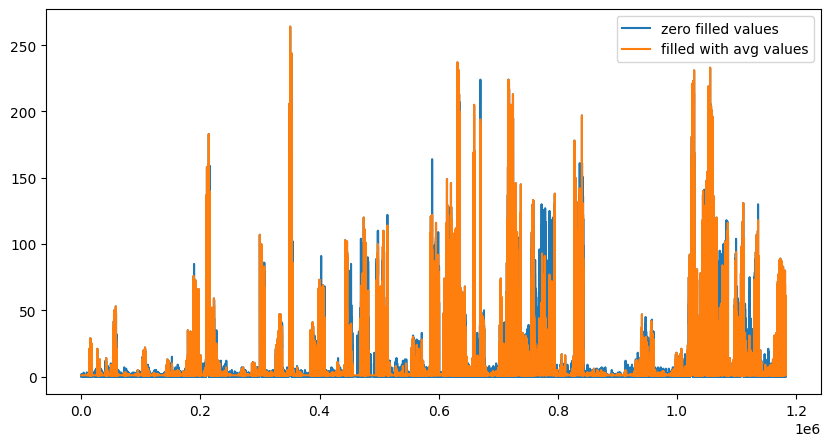

In [52]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2019_fill[0:1182960], label="zero filled values")
plt.plot(jan_2019_smooth[0:1182960], label="filled with avg values")
plt.legend()
plt.show()


In [54]:
# Jan-2015 data is smoothed, Jan,Feb & March 2016 data missing values are filled with zero
jan_2019_smooth = smoothing(jan_2019_groupby['trip_distance'].values,jan_2019_unique)
jan_2020_smooth = fill_missing(jan_2020_groupby['trip_distance'].values,jan_2020_unique)
feb_2020_smooth = fill_missing(feb_2020_groupby['trip_distance'].values,feb_2020_unique)
mar_2020_smooth = fill_missing(mar_2020_groupby['trip_distance'].values,mar_2020_unique)

# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# number of 10min indices for jan 2019= 24*31*60/10 = 4464
# number of 10min indices for jan 2020 = 24*31*60/10 = 4464
# number of 10min indices for feb 2020 = 24*29*60/10 = 4176
# number of 10min indices for march 2020 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

for i in range(1,266):
    regions_cum.append(jan_2020_smooth[4464*i:4464*(i+1)]+feb_2020_smooth[4176*i:4176*(i+1)]+mar_2020_smooth[4464*i:4464*(i+1)])

# print(len(regions_cum))
# 40
# print(len(regions_cum[0]))
# 13104

## Time series and Fourier Transforms

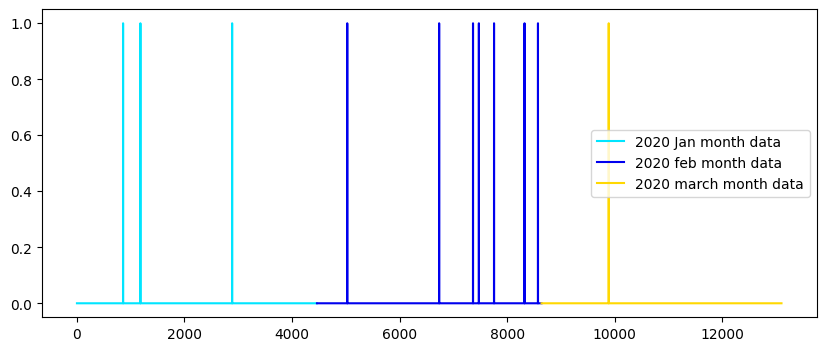

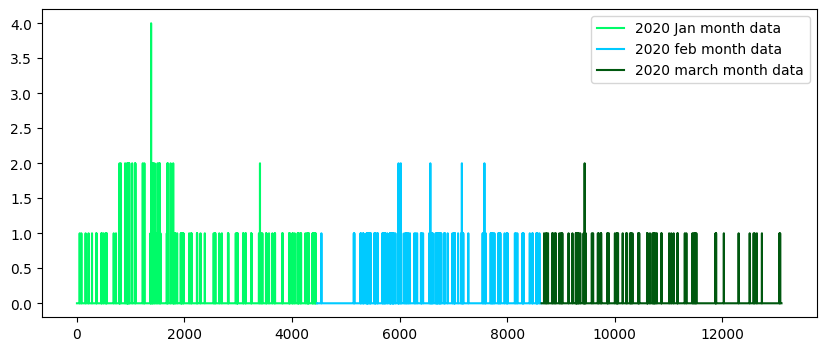

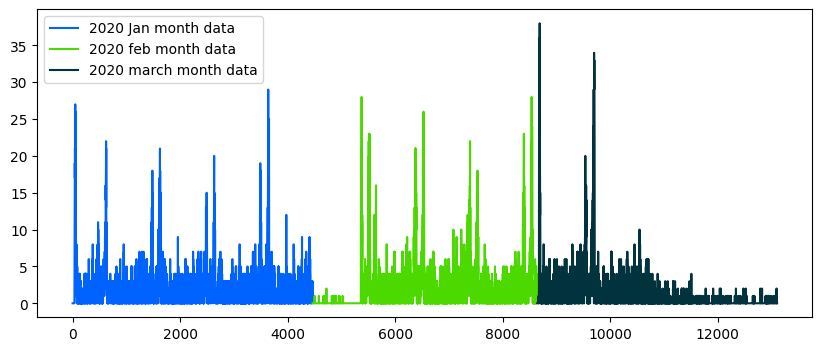

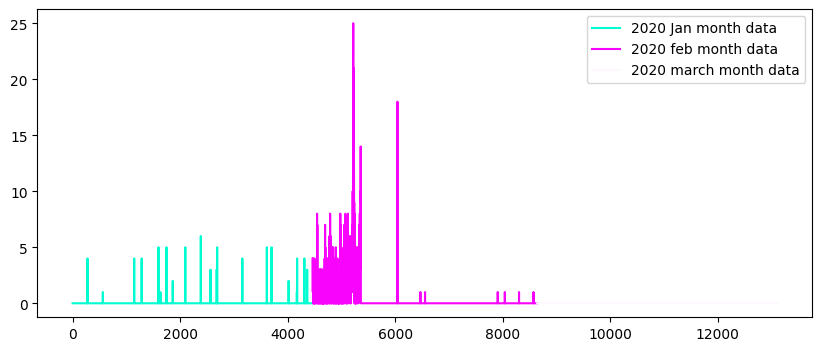

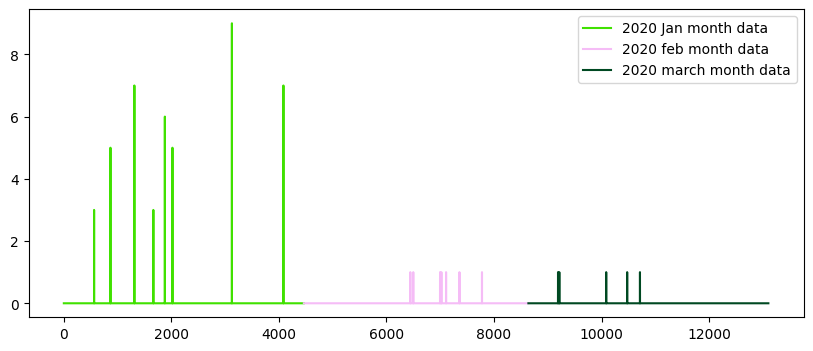

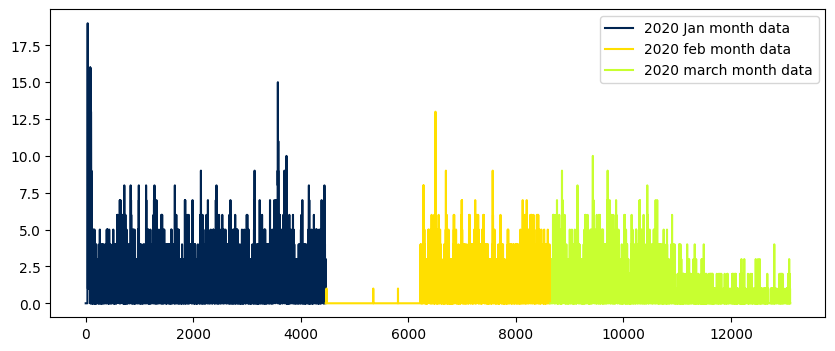

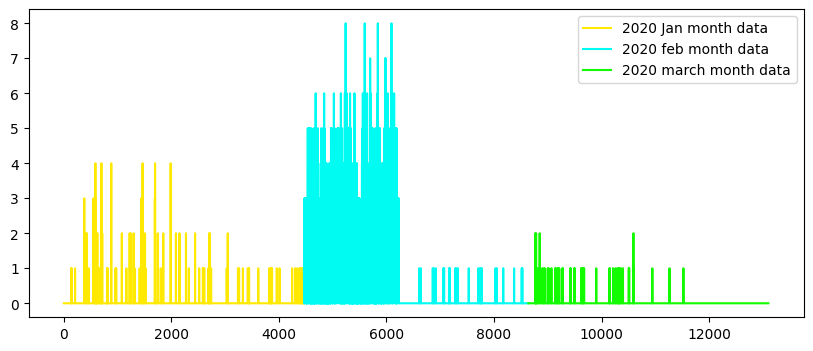

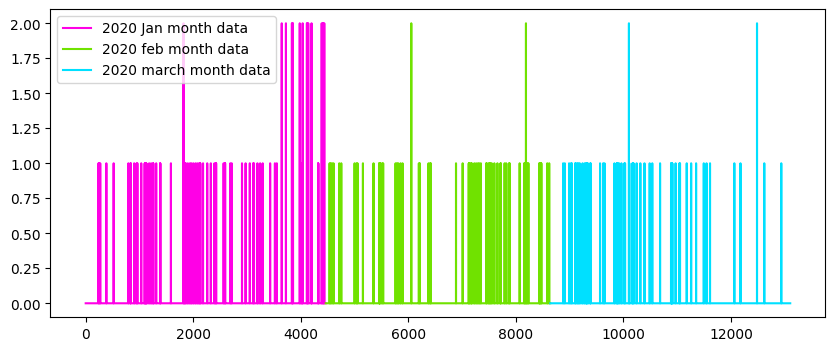

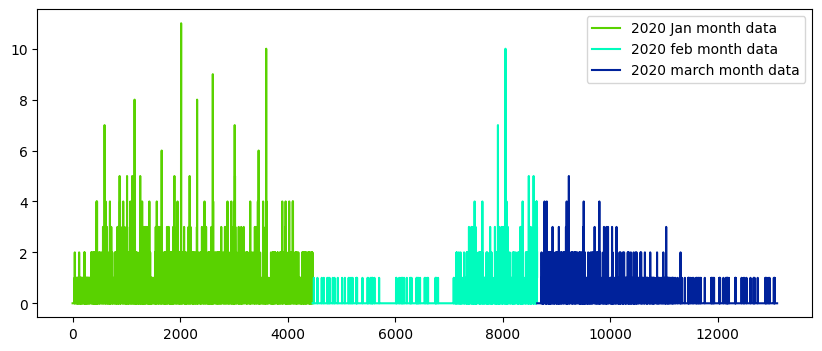

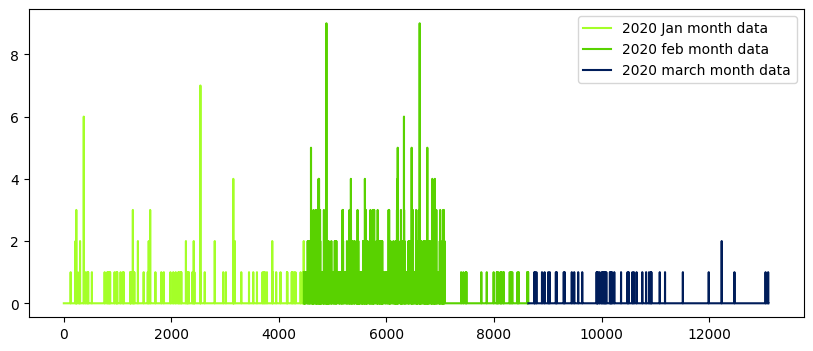

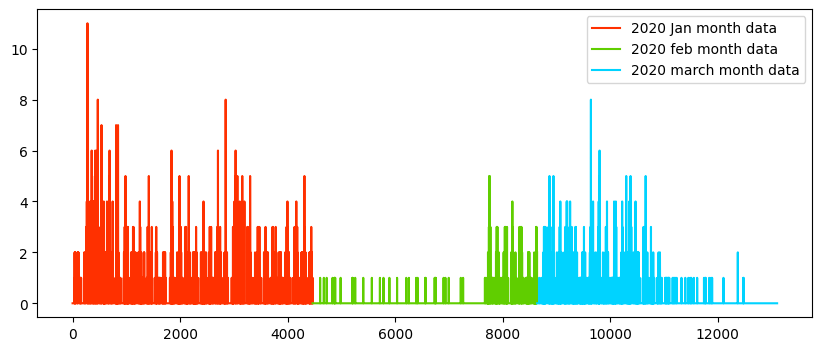

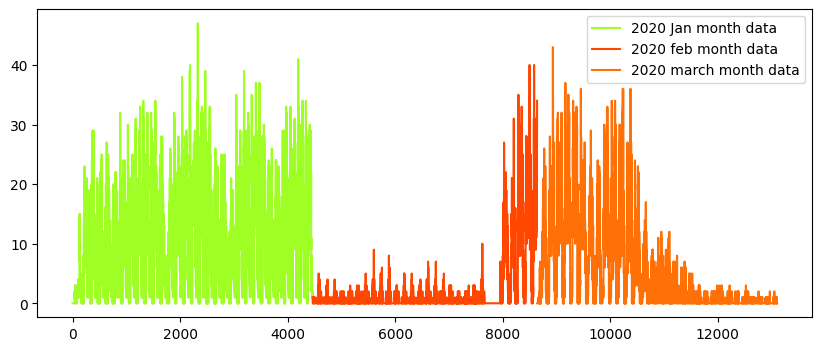

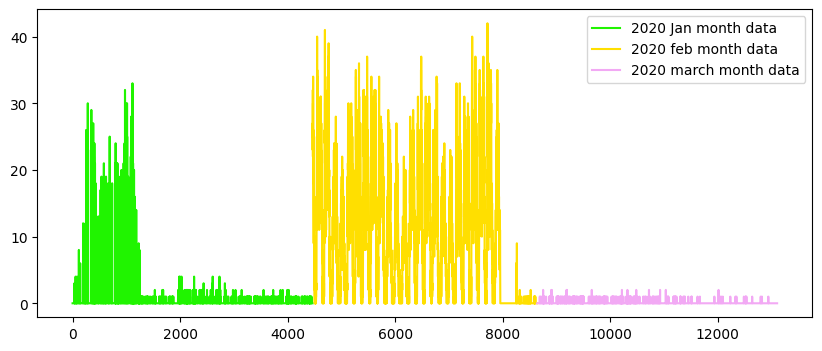

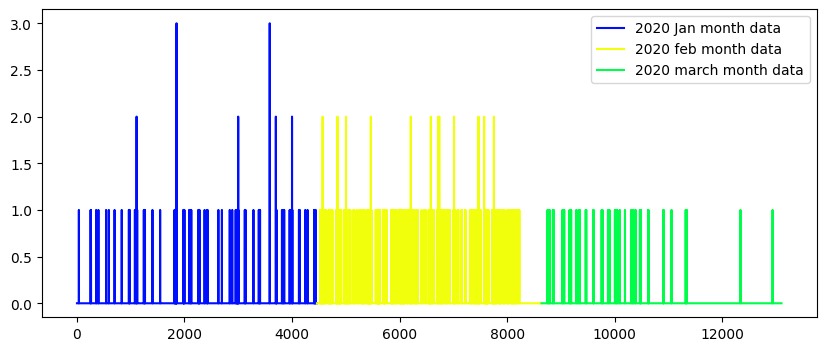

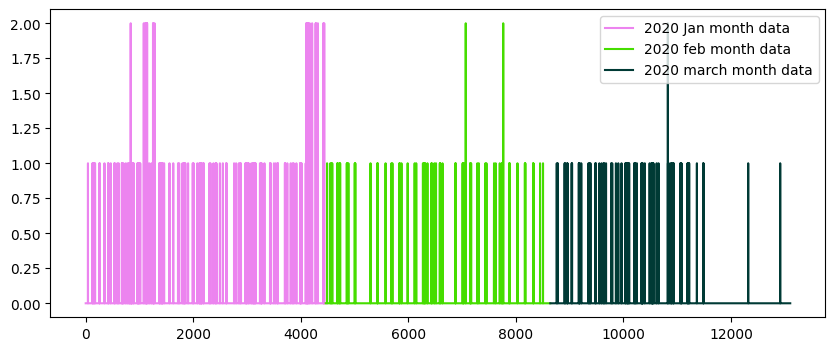

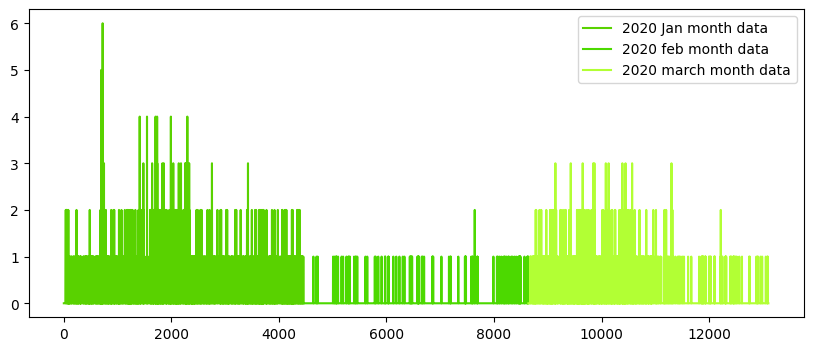

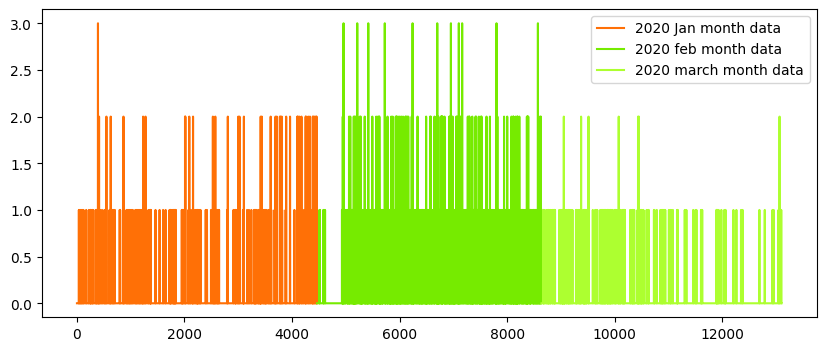

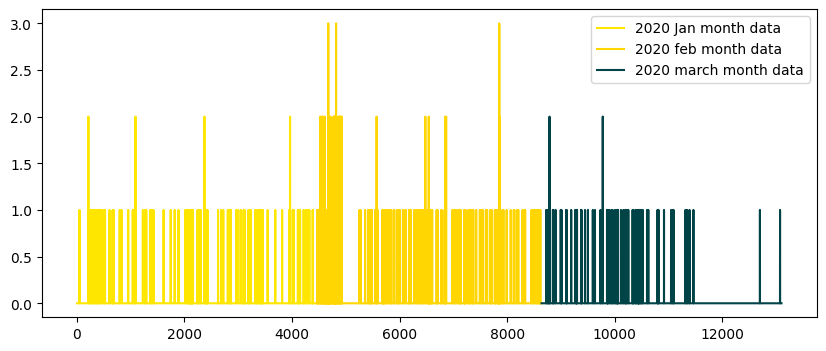

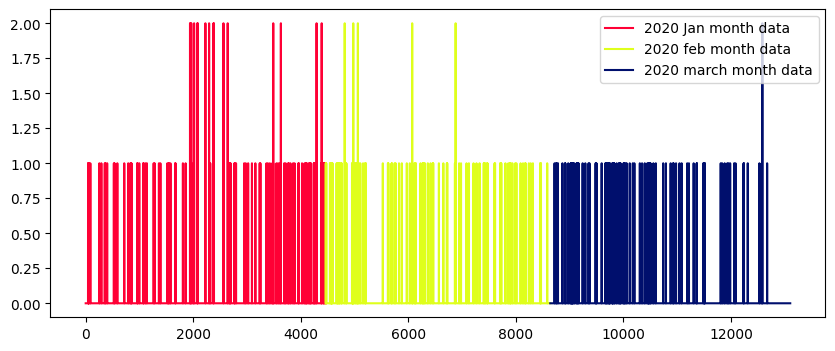

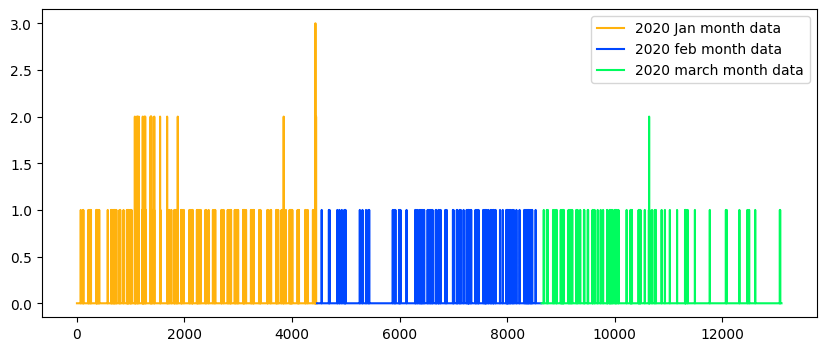

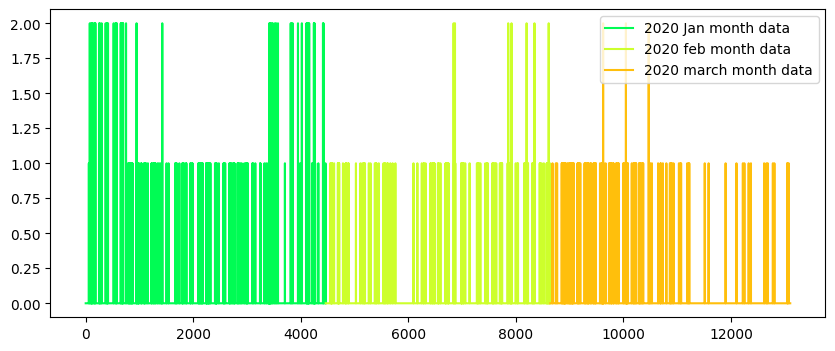

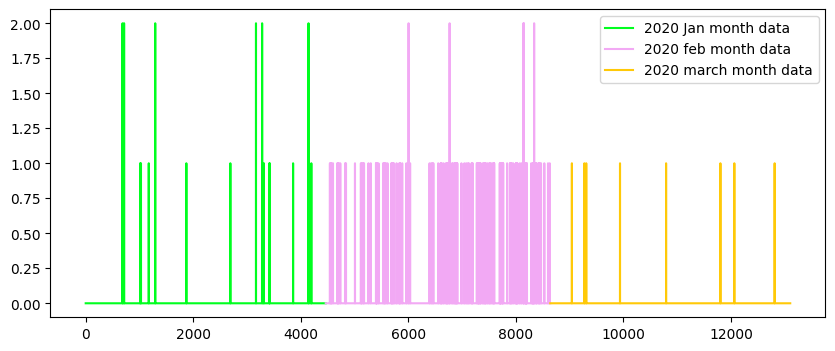

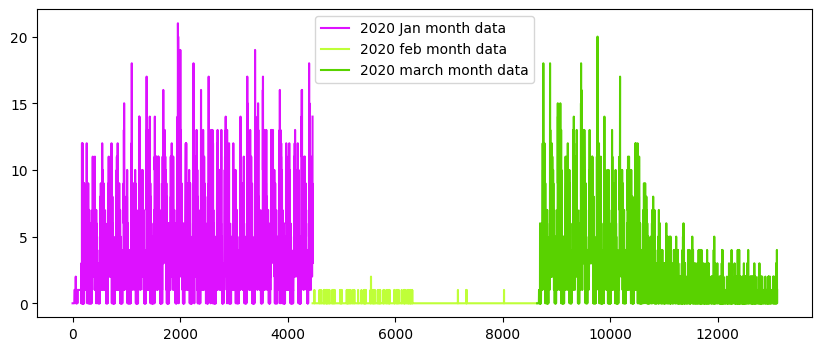

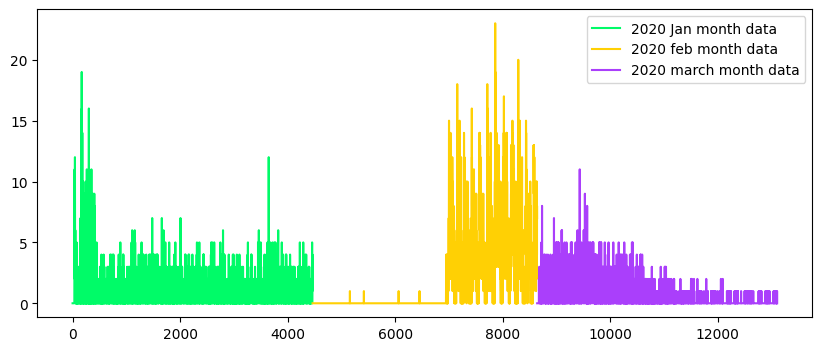

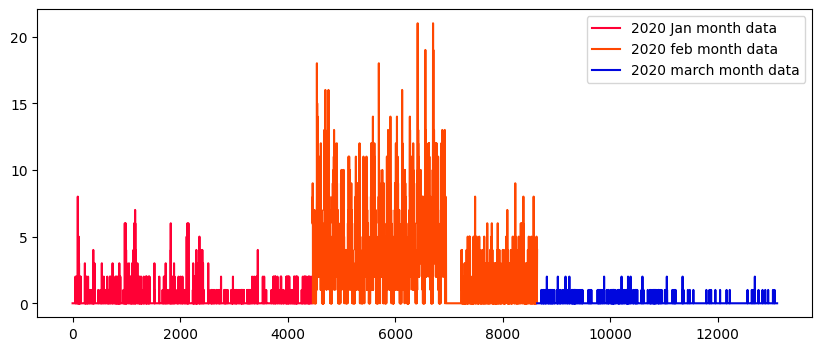

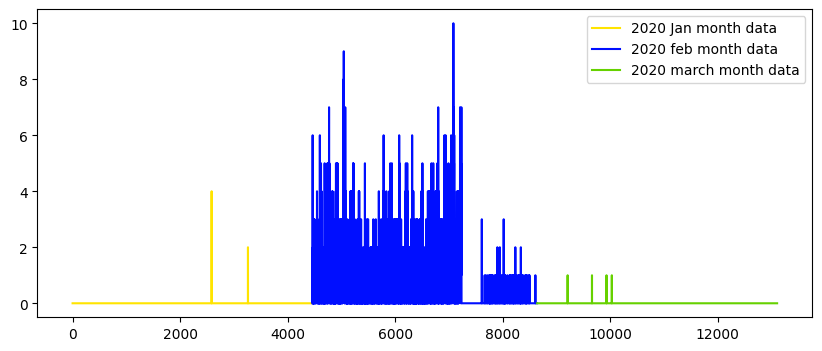

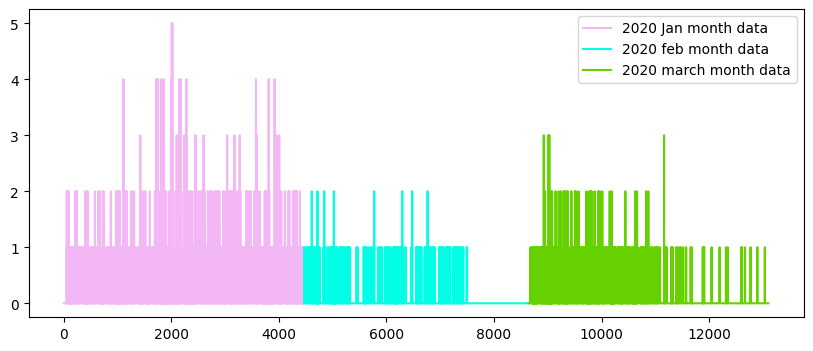

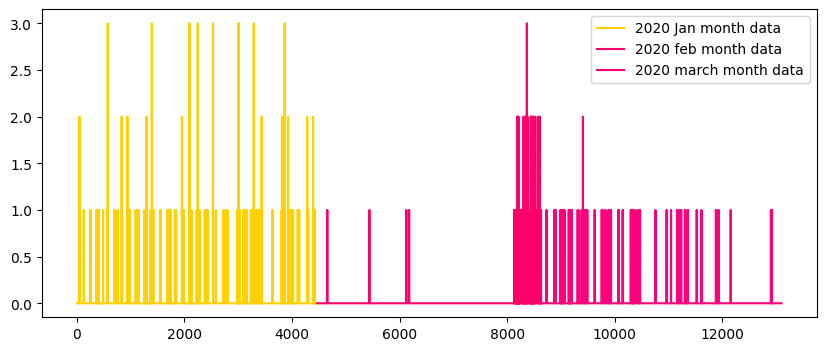

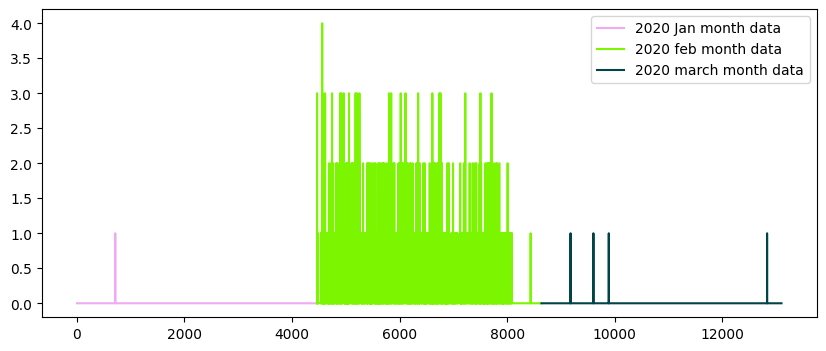

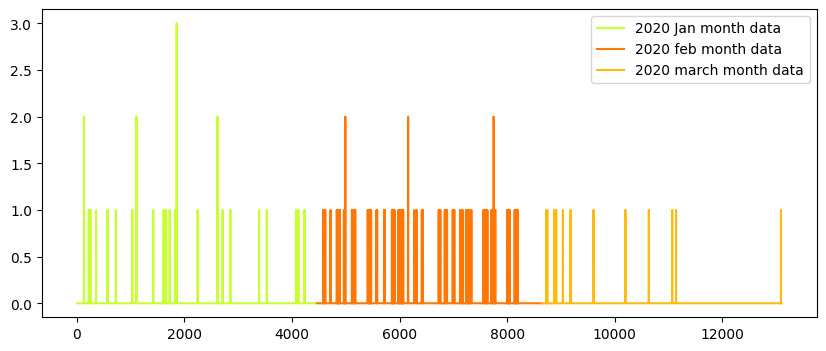

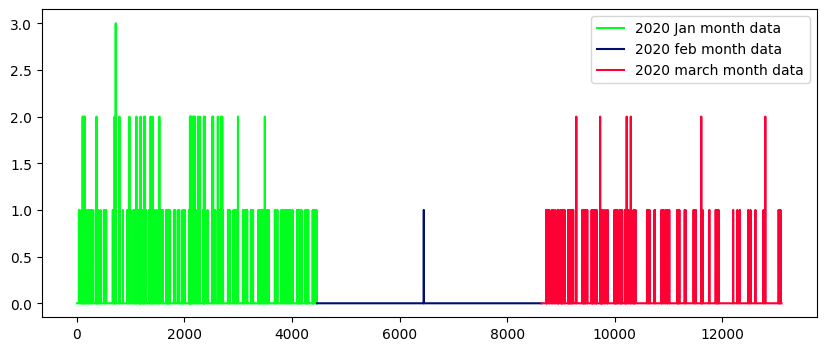

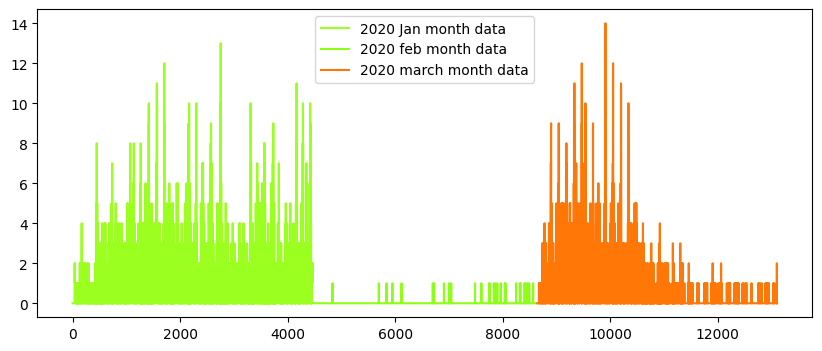

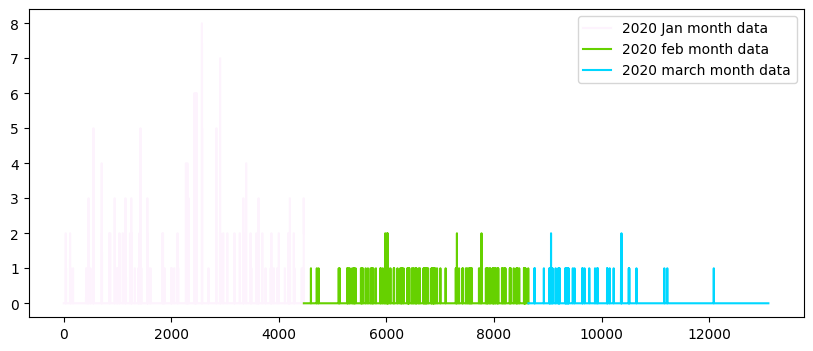

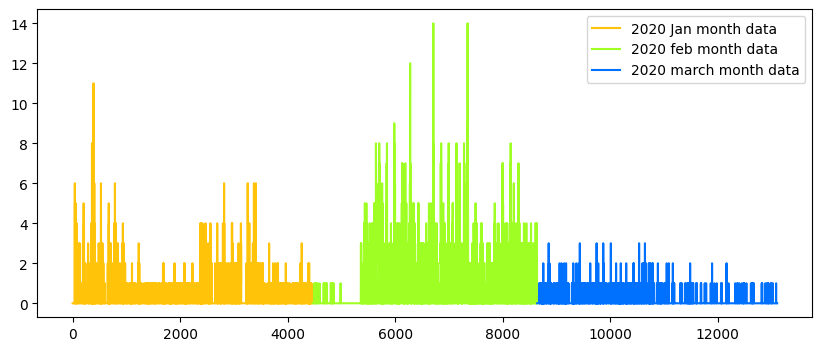

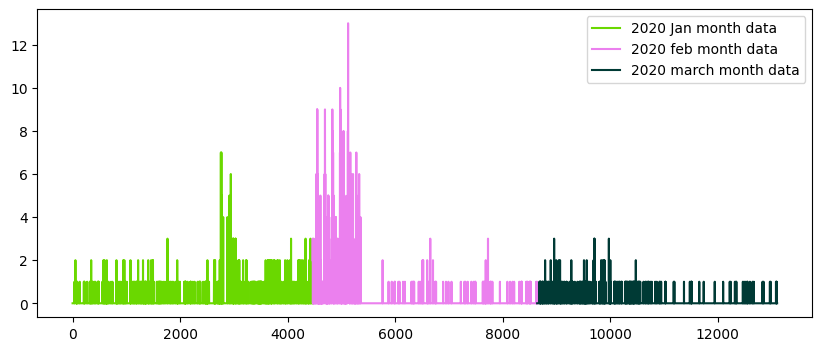

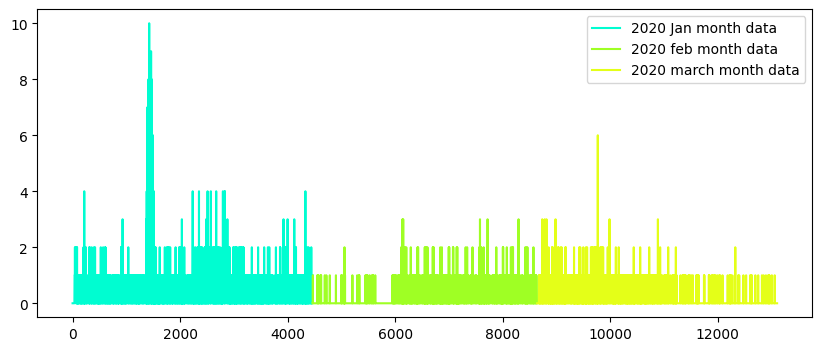

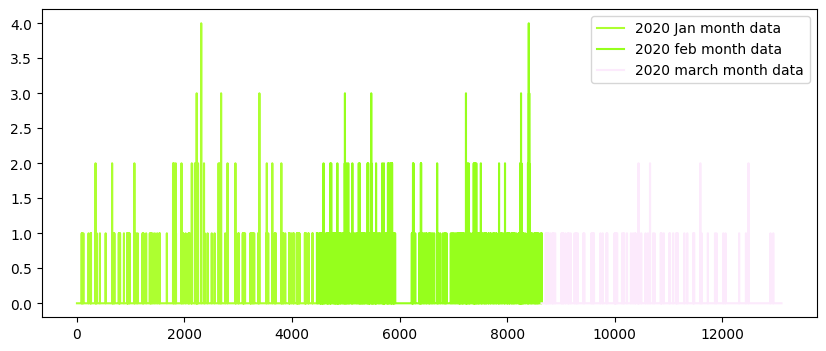

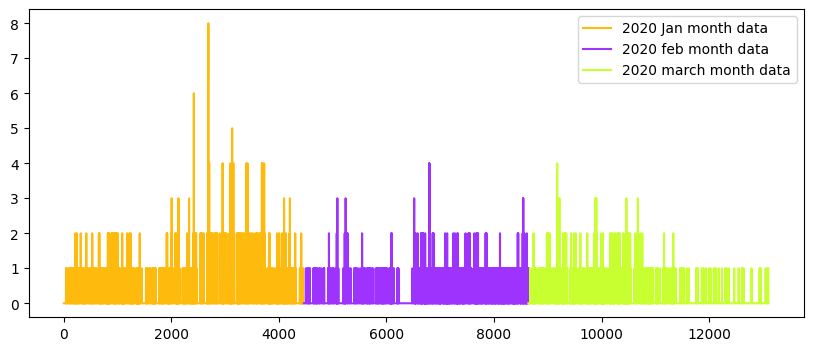

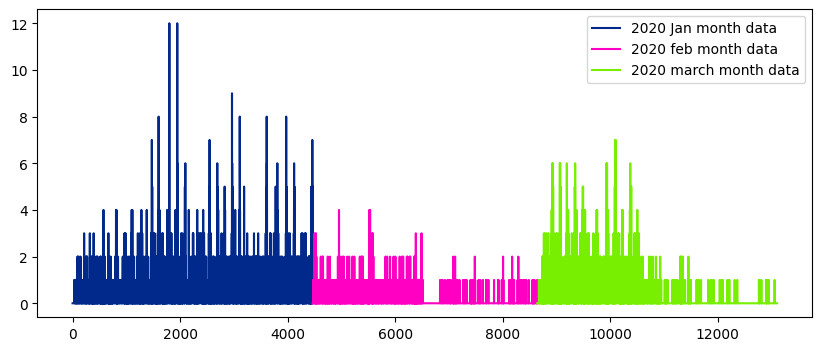

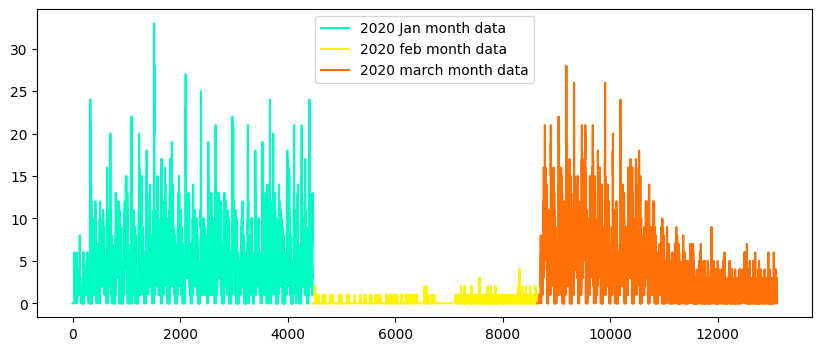

In [55]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))
for i in range(40):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2020 Jan month data')
    plt.plot(second_x,regions_cum[i][4464:8640], color=uniqueish_color(), label='2020 feb month data')
    plt.plot(third_x,regions_cum[i][8640:], color=uniqueish_color(), label='2020 march month data')
    plt.legend()
    plt.show()

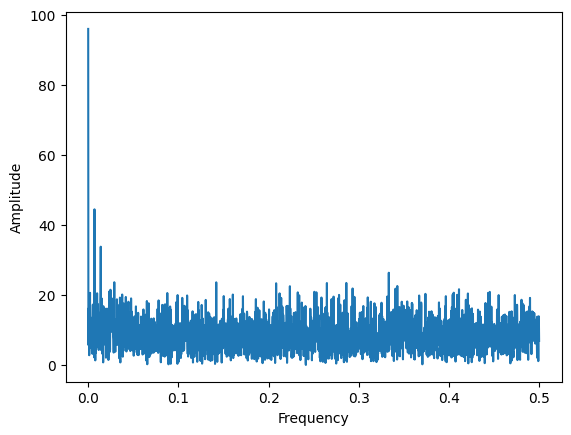

In [56]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(np.array(jan_2020_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [57]:
#Preparing the Dataframe only with x(i) values as jan-2015 data and y(i) values as jan-2016
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2019_smooth
ratios_jan['Prediction']=jan_2020_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [58]:
ratios_jan.shape

(1182960, 3)

# 3. Modeling

## 3-1.Simple Moving Averages

In [69]:
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(4464*265):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [68]:
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(4464*265):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

## 3-2.Weighted Moving Averages

In [67]:
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(4464*265):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [66]:
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(4464*265):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

## 3-3.Exponential Weighted Moving Averages

In [65]:
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(4464*265):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [64]:
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(4464*265):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [70]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

# Comparison between baseline models

In [71]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2016 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2016 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2016 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.5297644029392619       MSE:  204.00821498613647
Moving Averages (2016 Values) -                        MAPE:  0.42292007228698625        MSE:  66.45720227226617
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.5242330047967743       MSE:  183.16606985865963
Weighted Moving Averages (2016 Values) -               MAPE:  0.3975247648085794       MSE:  52.93061303847975
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.5219759528869758       MSE:  157.61526763373234
Exponential Moving Averages (2016 Values) -         MAPE:  0.393254045062

## Regression Models

### Regression Models

In [72]:
# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

# print(len(regions_cum))
# 40
# print(len(regions_cum[0]))
# 12960

# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 13099 for each cluster
output = []


# tsne_lat will contain 13104-5=13099 times lattitude of cluster center for every cluster
# Ex: [[cent_lat 13099times],[cent_lat 13099times], [cent_lat 13099times].... 40 lists]
# it is list of lists
tsne_lat = []


# tsne_lon will contain 13104-5=13099 times logitude of cluster center for every cluster
# Ex: [[cent_long 13099times],[cent_long 13099times], [cent_long 13099times].... 40 lists]
# it is list of lists
tsne_lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 13099 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(0,40):
    # tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    # tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    # jan 1st 2016 is thursday, so we start our day from 4: "(int(k/144))%7+4"
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    # regions_cum is a list of lists [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]

In [73]:
tsne_feature.shape[0] == len(tsne_weekday)*len(tsne_weekday[0]) == 40*13099 == len(output)*len(output[0])

True

In [74]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [75]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 3 months of 2016 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
print("size of train data :", int(13099*0.7))
print("size of test data :", int(13099*0.3))

size of train data : 9169
size of test data : 3929


In [76]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[i*13099:(13099*i+9169)] for i in range(0,40)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(13099*(i))+9169:13099*(i+1)] for i in range(0,40)]

In [77]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 40 Number of data points in trian data 9169 Each data point contains 5 features
Number of data clusters 40 Number of data points in test data 3930 Each data point contains 5 features


In [78]:
# extracting first 9169 timestamp values i.e 70% of 13099 (total timestamps) for our training data
# tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
# tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

In [79]:
# extracting the rest of the timestamp values i.e 30% of 12956 (total timestamps) for our test data
# tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
# tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]

In [80]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,40):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,40):
    test_new_features.extend(test_features[i])

In [81]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

# tsne_train_lat = sum(tsne_train_flat_lat, [])
# tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [82]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

# tsne_test_lat = sum(tsne_test_flat_lat, [])
# tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [83]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
# df_train['lat'] = tsne_train_lat
# df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(366760, 7)


In [84]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
# df_test['lat'] = tsne_test_lat
# df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(157200, 7)


In [85]:
df_test.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,weekday,exp_avg
0,0,0,0,0,0,4,0
1,0,0,0,0,0,4,0
2,0,0,0,0,0,4,0
3,0,0,0,0,0,4,0
4,0,0,0,0,0,4,0


## Using Linear Regression

In [86]:
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# -------------------------
# default paramters
# sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

# some of methods of LinearRegression()
# fit(X, y[, sample_weight])	Fit linear model.
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict using the linear model
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# set_params(**params)	Set the parameters of this estimator.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1-2-copy-8/
# -----------------------

from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression().fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

## Using Random Forest Regressor

In [87]:
# Training a hyper-parameter tuned random forest regressor on our train data
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# -------------------------
# default paramters
# sklearn.ensemble.RandomForestRegressor(n_estimators=10, criterion=’mse’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)

# some of methods of RandomForestRegressor()
# apply(X)	Apply trees in the forest to X, return leaf indices.
# decision_path(X)	Return the decision path in the forest
# fit(X, y[, sample_weight])	Build a forest of trees from the training set (X, y).
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict regression target for X.
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [88]:
# Predicting on test data using our trained random forest model 

# the models regr1 is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [89]:
#feature importances based on analysis using random forest
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'weekday', 'exp_avg'], dtype='object')
[0.06569979 0.14935811 0.19951572 0.19798612 0.15937563 0.01104149
 0.21702315]


## Using XgBoost Regressor

In [90]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBRegressor function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#module-xgboost.sklearn
# -------------------------
# default paramters
# xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', 
# booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
# colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, 
# missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=200, ...)

In [91]:
#predicting with our trained Xg-Boost regressor
# the models x_model is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

In [92]:
#feature importances
x_model.get_booster().get_score(importance_type="weight")

{'ft_5': 1036.0,
 'ft_4': 942.0,
 'ft_3': 1089.0,
 'ft_2': 923.0,
 'ft_1': 1003.0,
 'weekday': 494.0,
 'exp_avg': 881.0}

## Calculating the error metric values for various models

In [93]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output,df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [94]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.6305825742166787       Test:  0.7146742896742898
Exponential Averages Forecasting -           Train:  0.5408498413175786       Test:  0.5925155925155926
Linear Regression -                         Train:  0.5113174993866391       Test:  0.5664760914760916
Random Forest Regression -                   Train:  0.44789201681004803      Test:  0.568953568953569


## Error Metric Matrix

In [95]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[4],"      Test: ",test_mape[4])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])
print ("XgBoost Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.6305825742166787       Test:  0.7146742896742898
Exponential Averages Forecasting -           Train:  0.5408498413175786       Test:  0.5925155925155926
Linear Regression -                         Train:  0.5191843486106384       Test:  0.568918918918919
Random Forest Regression -                   Train:  0.44789201681004803      Test:  0.568953568953569
XgBoost Regression -                         Train:  0.5113174993866391       Test:  0.5664760914760916
--------------------------------------------------------------------------------------------------------
